# Laboratorio: Convolutional Neural Networks

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 2s 0us/step


In [2]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [3]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [4]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [5]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [6]:
y_t

array([16, 13,  7,  3,  3, 15,  8,  8, 10, 10, 16, 10, 10,  4,  2,  9,  4,
        1,  5,  4, 12, 15, 15,  0, 15, 12,  6, 10,  4, 17,  2,  6,  0,  2,
       13,  6,  3, 10, 14,  7, 16, 17, 13, 16, 10, 12,  4, 12, 17,  5,  1,
        7,  1, 16,  6, 13, 16,  2,  8,  0,  9,  3, 15,  6, 13, 15, 16,  4,
       10, 14,  5, 14, 10,  2,  8, 17, 10,  4, 12,  2, 10,  6,  3, 17, 13,
        5,  5,  9,  7,  7,  1,  3,  6, 14,  6, 11,  8, 11,  4,  9, 16, 11,
        2, 16,  2, 15,  1,  4, 17, 11,  5, 10,  0, 15, 11,  7,  5,  7,  9,
        1,  2,  4, 12,  6,  3, 14,  0,  7,  4,  1,  6,  2,  7,  8, 17,  9,
        7, 14, 10, 13,  0,  8,  2,  5,  0,  9, 14, 13, 12,  8, 16,  8, 11,
       17,  3,  3, 13,  0, 11,  1,  6, 13, 14,  6,  2, 12, 10, 16,  3,  3,
        6, 15,  6, 15,  2, 13, 13,  4,  2, 13, 10, 13,  4, 12,  9,  7,  1,
       11,  9, 10,  9, 14,  8,  6,  3,  3, 16, 17, 14,  2,  9,  0,  2, 10,
       13,  4,  0, 12, 10, 10,  8, 11,  0, 10,  7, 13, 14, 12, 11,  1,  9,
        6, 16, 10, 16, 17

In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Preparacion de datos

In [ ]:
# normalizar imagenes entre 0 y 1, además de pasar a categorical las labels de manera que al modelo
# le será más fácil reconocer la label que corresponde a la imagen.
from keras.utils import to_categorical

X, X_t = X / 255.0, X_t / 255.0
train_Y = to_categorical(y) # éste método convierte las strings a números
test_Y = to_categorical(y_t)

In [ ]:
# separamos los datos de entrenamiento de manera que 80% va a ser para train 
# y el 20% para test.
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(X , train_Y, test_size=0.2, random_state=2)

In [ ]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

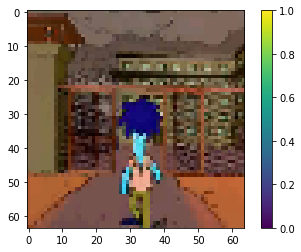

sideshow_bob
(64, 64, 3)


In [ ]:
visualize_example(X[70]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_CHARACTERS[y[70]]) # Acceso al diccionario
print(X[70].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

In [ ]:
#batch_size=128
num_classes=18
epochs=5
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(64,64,3)

In [ ]:
# creación del modelo convolucional
from keras import models, layers
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.layers import  BatchNormalization
 
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), input_shape=(64,64,3),activation="relu")) # capa convolucional
model.add(layers.MaxPooling2D(2,2)) # reduce las dimensiones de la image width y height y coge el valor máximo
BatchNormalization() # normaliza la entrada y aplica una transformación para que la media esté cerca del 0  y la stdv cerca del 1
model.add(layers.Dropout(0,2))
model.add(layers.Conv2D(64, (3,3),activation="relu"))
model.add(layers.MaxPooling2D(2,2))
BatchNormalization()
model.add(layers.Dropout(0,2)) # capa dropout para que añada valores nulo y no sobreentrene el modelo
model.add(layers.Conv2D(128, (3,3),activation="relu"))
model.add(layers.MaxPooling2D(2,2))
BatchNormalization()

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
BatchNormalization(  # ejemplo con parámetros a mano en vez de por defecto
    momentum=0.95, 
    epsilon=0.005,
    beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
    gamma_initializer=Constant(value=0.9)
)
model.add(layers.Dense(18, activation="softmax"))

In [ ]:
#resumen de los parámetros del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

In [ ]:
#compilador del modelo 
model.compile(optimizer = 'adam', # optimizador uso adam debido a que es bastante preciso en los problemas de clasificación cómo éste
             loss = 'categorical_crossentropy', # la clase de pérdida uso categorical_crossentropy ya que es el más adecuado 
              #usando el optimizador adams y siendo un problema de clasificación
             metrics = ['accuracy']) # y la métrica que uso principalmente es accuracy, sin embargo también puedes usar Recall()

In [ ]:
# creación de data augmentation con los parámetros
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X) # entrenamiento del data augmentation

In [ ]:
# entrenamiento del modelo usando data augmentation
train_log = model.fit(datagen.flow(x_train, y_train, batch_size=70),
          epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
218/218 [==============================] - 31s 93ms/step - loss: 2.3712 - accuracy: 0.2616 - val_loss: 1.6923 - val_accuracy: 0.4946
Epoch 2/20
218/218 [==============================] - 19s 88ms/step - loss: 1.7162 - accuracy: 0.4826 - val_loss: 1.4035 - val_accuracy: 0.5796
Epoch 3/20
218/218 [==============================] - 19s 88ms/step - loss: 1.3465 - accuracy: 0.5909 - val_loss: 1.0262 - val_accuracy: 0.6799
Epoch 4/20
218/218 [==============================] - 21s 95ms/step - loss: 1.1036 - accuracy: 0.6634 - val_loss: 0.8511 - val_accuracy: 0.7341
Epoch 5/20
218/218 [==============================] - 18s 84ms/step - loss: 0.9565 - accuracy: 0.7084 - val_loss: 0.7399 - val_accuracy: 0.7728
Epoch 6/20
218/218 [==============================] - 18s 84ms/step - loss: 0.8450 - accuracy: 0.7448 - val_loss: 0.7631 - val_accuracy: 0.7742
Epoch 7/20
218/218 [==============================] - 19s 88ms/step - loss: 0.7501 - accuracy: 0.7701 - val_loss: 0.6298 - val_accuracy:

In [ ]:
# ver la pérdida y la precisión del modelo
loss,accuracy = model.evaluate(X_t,test_Y)

28/28 [==============================] - 0s 7ms/step - loss: 0.2638 - accuracy: 0.9213


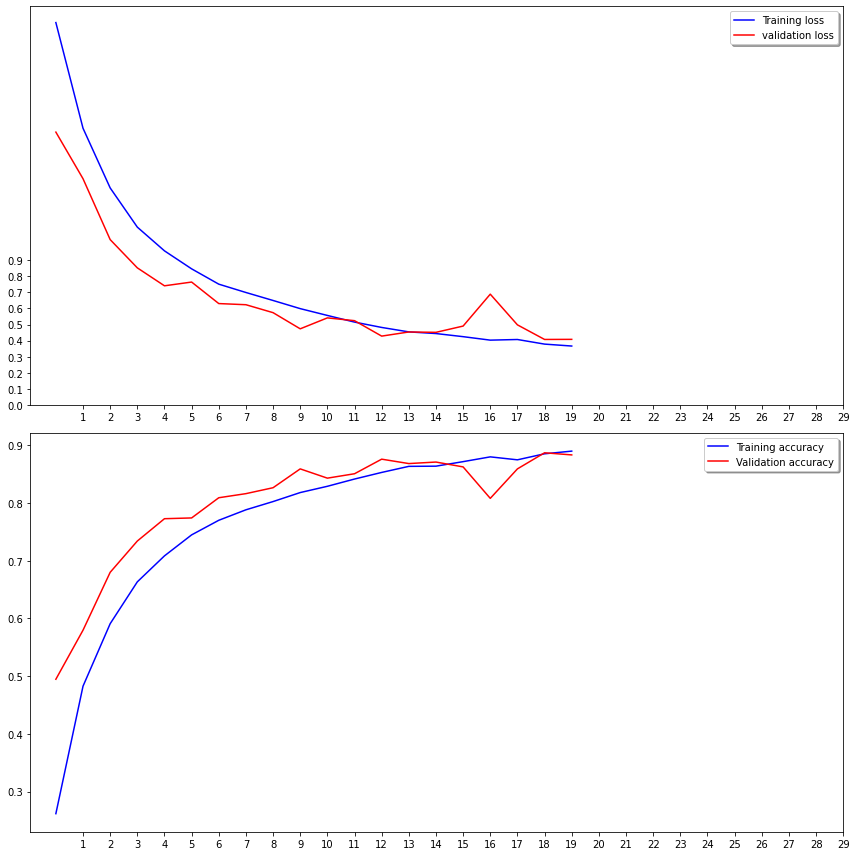

In [ ]:
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(train_log.history['loss'], color='b', label="Training loss")
ax1.plot(train_log.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True)
ax2.plot(train_log.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(train_log.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax2.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


In [ ]:
# análisis de resultados del modelo
from sklearn.metrics import confusion_matrix, classification_report
prediccion = model.predict(X_t)
informe = classification_report(np.argmax(test_Y, axis=1), np.argmax(prediccion, axis=1), target_names = list(MAP_CHARACTERS.values()))
print(informe)

28/28 [==============================] - 0s 3ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.83      0.90        48
  apu_nahasapeemapetilon       1.00      0.98      0.99        50
            bart_simpson       0.85      0.88      0.86        50
charles_montgomery_burns       0.95      0.83      0.89        48
            chief_wiggum       0.92      0.96      0.94        50
          comic_book_guy       0.98      0.88      0.92        49
          edna_krabappel       0.98      0.88      0.93        50
           homer_simpson       0.66      0.96      0.78        50
           kent_brockman       0.87      0.96      0.91        50
        krusty_the_clown       0.98      0.98      0.98        50
            lisa_simpson       0.92      0.88      0.90        50
           marge_simpson       0.98      1.00      0.99        50
     milhouse_van_houten       0.94      0.96      0.95        49
             moe_szysl

In [ ]:
# creación del modelo fully connected
model_2 = models.Sequential() 
model_2.add(layers.Flatten(input_shape=(64,64,3)))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dense(18, activation='softmax'))

In [ ]:
#compoilador
model_2.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [ ]:
# entrenaimento del modelo
train_log = model_2.fit(x_train, y_train, 
                      epochs=20, batch_size=70,
                     validation_data=(x_val, y_val))

Epoch 1/20
218/218 [==============================] - 3s 9ms/step - loss: 2.4387 - accuracy: 0.2410 - val_loss: 2.2384 - val_accuracy: 0.2964
Epoch 2/20
218/218 [==============================] - 1s 6ms/step - loss: 2.0947 - accuracy: 0.3523 - val_loss: 2.0909 - val_accuracy: 0.3538
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 1.9456 - accuracy: 0.3974 - val_loss: 2.0877 - val_accuracy: 0.3611
Epoch 4/20
218/218 [==============================] - 1s 6ms/step - loss: 1.8533 - accuracy: 0.4275 - val_loss: 1.9780 - val_accuracy: 0.3912
Epoch 5/20
218/218 [==============================] - 1s 6ms/step - loss: 1.7626 - accuracy: 0.4524 - val_loss: 1.8939 - val_accuracy: 0.4159
Epoch 6/20
218/218 [==============================] - 1s 7ms/step - loss: 1.6790 - accuracy: 0.4740 - val_loss: 1.8008 - val_accuracy: 0.4459
Epoch 7/20
218/218 [==============================] - 2s 8ms/step - loss: 1.5982 - accuracy: 0.5014 - val_loss: 1.8146 - val_accuracy: 0.4528
Epoch 

In [ ]:
# ver pérdida y precisión
loss_2,accuracy_2 = model_2.evaluate(X_t,test_Y)

28/28 [==============================] - 0s 3ms/step - loss: 1.5022 - accuracy: 0.5404


In [ ]:
# ver params del modelo
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                786496    
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 18)                4626      
                                                                 
Total params: 898,258
Trainable params: 898,258
Non-tr

In [ ]:
# análisis de resultados
prediccion = model_2.predict(X_t)
informe = classification_report(np.argmax(test_Y, axis=1), np.argmax(prediccion, axis=1), target_names = list(MAP_CHARACTERS.values()))
print(informe)

28/28 [==============================] - 0s 2ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.58      0.31      0.41        48
  apu_nahasapeemapetilon       0.50      0.82      0.62        50
            bart_simpson       0.45      0.42      0.43        50
charles_montgomery_burns       0.87      0.42      0.56        48
            chief_wiggum       0.62      0.70      0.66        50
          comic_book_guy       0.69      0.18      0.29        49
          edna_krabappel       0.68      0.56      0.62        50
           homer_simpson       0.35      0.44      0.39        50
           kent_brockman       0.84      0.62      0.71        50
        krusty_the_clown       0.40      0.76      0.52        50
            lisa_simpson       0.55      0.32      0.41        50
           marge_simpson       0.57      0.76      0.65        50
     milhouse_van_houten       0.42      0.71      0.53        49
             moe_szysl

# Analisis de datos

# Modelo

# Analisis de resultados y visual de los errores

Vemos como se obtienen mejores resultados con recall que con la métrica de precisión.
Además podemos apreciar como las imágenes de bart simpson, homer simpson y charles montgomery son las imágenes que más le cuesta al modelo reconocer.


# Comparación de modelos (Fully Connected)

Finalmente, el modelo convolucional es mucho mejor para predecir imágenes que un fully connected, además de observar que la diferencia de precisiones es abismal y incluso a pesar de que el 2º modelo trabaje más rapido que el otro, no es capaz de predecir las imágenes.